In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'

In [3]:
from jwave.geometry import Domain, Medium, TimeAxis, Sources
from jwave import FourierSeries
from jax import numpy as jnp

In [4]:
# Domain
N = (256, 256)
domain = Domain( N, (.5,.5))

# Physical properties
sound_speed = jnp.ones(N)
sound_speed = jnp.expand_dims(sound_speed.at[N[0]//2:].set(1.3), -1)
sound_speed = FourierSeries(sound_speed, domain)

density = jnp.ones(N)
density = jnp.expand_dims(density.at[:,N[1]//4:].set(1.2), -1)
density = FourierSeries(density, domain)

medium = Medium(
    domain=domain,
    sound_speed = sound_speed,
    density = density,
    attenuation = 0,
    pml_size = 30.
)

time_axis = TimeAxis.from_medium(medium, cfl=0.1, t_end=200.)

In [5]:
# Defining source points
from jwave.signal_processing import apply_ramp

source_freq = 0.1 
source_mag = 5

def gaussian_window(signal, time, mu, sigma):
    return signal*jnp.exp(
        -(t-mu)**2/sigma**2
    )

t = jnp.arange(0, time_axis.t_end, time_axis.dt)
s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t)
s1 = gaussian_window(
    apply_ramp(s1, time_axis.dt, source_freq),
    t,
    20,
    10
)

source_signals = jnp.stack([s1])
source_positions = ([128], [384,])

sources = Sources(
    positions=source_positions, 
    signals=source_signals, 
    dt=time_axis.dt,
    domain=domain
)

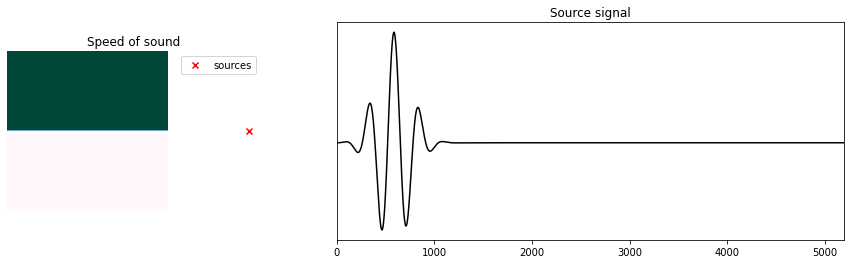

In [6]:
# Show simulation setup
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4), gridspec_kw={'width_ratios': [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="PuBuGn_r")
ax[0].scatter(source_positions[1],source_positions[0], c='r', marker='x', label="sources")
ax[0].legend()
ax[0].set_title("Speed of sound")
ax[0].axis("off")

ax[1].plot(s1, label="Source ", c='k')
ax[1].set_title("Source signal")
ax[1].set_xlim([0,s1.shape[0]])
ax[1].get_yaxis().set_visible(False)

In [7]:
from jwave.acoustics.time_varying import simulate_wave_equation
from jax import jit

fields = simulate_wave_equation(medium, time_axis, sources)

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

# Point sources in heterogeneous media

*This example notebook follows the [Heterogeneous Propagation Medium Example](http://www.k-wave.org/documentation/example_ivp_heterogeneous_medium.php) of [k-Wave](http://www.k-wave.org/)., but uses point mass sources*

## Setup the problem

## Run the simulation

In [5]:
from jwave.acoustics import ongrid_wave_propagation
from jax import jit

# Setup simiulation
output_taxis = TimeAxis(dt=time_axis.dt*10, t_end=time_axis.t_end)
params, solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    sources=sources,
    output_t_axis = output_taxis
)
solver = jit(solver)

In [6]:
fields = solver(params)

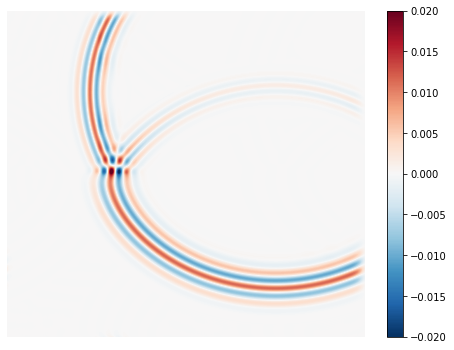

In [8]:
from jwave.utils import show_field

show_field(fields[400], vmax=0.02)

In [9]:
!mkdir ./tmp

In [10]:
# Plot slices of the array and save to a gif
import matplotlib.pyplot as plt
import imageio
import os
from tqdm import trange

In [11]:
array = fields#[:1000]
filename = './tmp/wave'

for i in trange(array.shape[0]):
    img_data = array[i]
    show_field(img_data, vmax=0.02)
    # Save with leading zeros  
    plt.savefig(f'{filename}_{i:04}.png')
    plt.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 521/521 [01:59<00:00,  4.36it/s]


In [12]:
writer = imageio.get_writer('./videos/wave_propagation.mp4', fps=30)
for filename in sorted(os.listdir('./tmp/')):
    im = imageio.imread('./tmp/' + filename)
    writer.append_data(im)
writer.close()

In [13]:
!rm -rf ./tmp

<video src="./videos/wave_propagation.mp4" controls="controls"></video>